In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    r2_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
df = pd.read_csv('../data/processed/combined-swell-classification-hrv-train-dataset.csv')

In [4]:
val = pd.read_csv('../data/processed/combined-swell-classification-hrv-validation-dataset.csv')

In [5]:
test = pd.read_csv('../data/processed/combined-swell-classification-hrv-test-dataset.csv')

In [6]:
df = pd.concat([df, val]) # 352474 entries to train and validated combined

In [7]:
## NOTES ON FEATURES
# RR is the peak in a heartbeat
# RR interval (RRI) is the distance between peaks in milliseconds between beats from an ECG
# RMSDD is the square root of the mean distance between RR for a period of time
# RMSDD is used as HRV calculation based on one minute intervals
# SDNN is the standard deviaiton of all the RR intervals

## NOTES ON EXPERIMENT CONDITIONS
# Conditions are R: rest, N: no stress, T: time pressure, I: interruption 
# No stress - Allowed to work for a maximum 45 minutes but they don't know the duration 
# Time Pressure - Time limit of 2/3 to complete task based on duration in no stress
# Interruption - Received 8 emails in the middle of the assigned task 

## NOTES ON STRESS QUSTIONNAIRE TAKEN AFTER EVERY EXPERIMENT CONDITION

# NASA TLX - NASA Task Load Index is used as a measure of mental load: High, Medium, Low
# multi-dimensional rating for mental demand, physical demand, temporal deman, effort,
# performance, and frustration

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352474 entries, 0 to 39163
Data columns (total 69 columns):
MEAN_RR                     352474 non-null float64
MEDIAN_RR                   352474 non-null float64
SDRR                        352474 non-null float64
RMSSD                       352474 non-null float64
SDSD                        352474 non-null float64
SDRR_RMSSD                  352474 non-null float64
HR                          352474 non-null float64
pNN25                       352474 non-null float64
pNN50                       352474 non-null float64
SD1                         352474 non-null float64
SD2                         352474 non-null float64
KURT                        352474 non-null float64
SKEW                        352474 non-null float64
MEAN_REL_RR                 352474 non-null float64
MEDIAN_REL_RR               352474 non-null float64
SDRR_REL_RR                 352474 non-null float64
RMSSD_REL_RR                352474 non-null float64
SDSD_R

In [9]:
df.describe()

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,...,SD1_BOXCOX,KURT_SQUARE,HR_SQRT,MEAN_RR_MEAN_MEAN_REL_RR,SD2_LF,HR_LF,HR_HF,HF_VLF,Condition Label,NasaTLX Label
count,352474.000000,352474.000000,352474.000000,352474.000000,352474.000000,352474.000000,352474.000000,352474.000000,352474.000000,352474.000000,...,352474.000000,3.524740e+05,352474.000000,3.524740e+05,352474.000000,352474.000000,352474.000000,352474.000000,352474.000000,352474.000000
mean,838.474161,834.060686,109.052370,14.979317,14.978579,7.395047,74.589986,9.872043,0.871194,10.594989,...,402.359505,3.576022e+00,8.617103,7.549407e+06,0.233577,0.111791,6.390759,0.033403,0.632501,1.002298
std,119.673432,128.724227,77.289341,4.155247,4.155266,5.202027,10.071975,8.272959,0.986410,2.939197,...,1719.396930,3.219256e+01,0.579250,3.622634e+09,0.442579,0.076299,26.486456,0.042141,0.762709,0.817129
min,547.483802,517.293295,27.233947,5.529742,5.529630,2.660381,48.736986,0.000000,0.000000,3.911344,...,0.124982,7.720668e-11,6.981188,-3.087910e+11,0.034754,0.021164,0.261909,0.000037,0.000000,0.000000
25%,757.424245,752.467675,64.034262,11.791692,11.791217,4.488405,67.685208,3.666667,0.000000,8.340432,...,0.730927,5.432918e-02,8.227102,-1.146890e+07,0.096666,0.059504,1.630844,0.005790,0.000000,0.000000
50%,816.019266,813.608335,82.708594,14.425784,14.425275,5.939964,74.708813,7.600000,0.466667,10.203614,...,1.716107,2.317773e-01,8.643426,-1.109307e+06,0.162875,0.093536,2.944486,0.017340,0.000000,1.000000
75%,907.524817,900.568145,117.912508,17.976917,17.975643,7.946475,80.750069,13.133333,1.466667,12.714941,...,17.531453,9.181949e-01,8.986104,1.170531e+07,0.225817,0.136960,5.512633,0.043372,1.000000,2.000000
max,1322.016957,1653.122250,563.486949,26.629477,26.629392,54.523950,113.754253,39.400000,5.400000,18.836107,...,12664.594280,4.107285e+03,10.665564,1.444233e+12,8.509626,0.650805,881.163906,0.289905,2.000000,2.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352474 entries, 0 to 39163
Data columns (total 69 columns):
MEAN_RR                     352474 non-null float64
MEDIAN_RR                   352474 non-null float64
SDRR                        352474 non-null float64
RMSSD                       352474 non-null float64
SDSD                        352474 non-null float64
SDRR_RMSSD                  352474 non-null float64
HR                          352474 non-null float64
pNN25                       352474 non-null float64
pNN50                       352474 non-null float64
SD1                         352474 non-null float64
SD2                         352474 non-null float64
KURT                        352474 non-null float64
SKEW                        352474 non-null float64
MEAN_REL_RR                 352474 non-null float64
MEDIAN_REL_RR               352474 non-null float64
SDRR_REL_RR                 352474 non-null float64
RMSSD_REL_RR                352474 non-null float64
SDSD_R

In [11]:
df.columns

Index(['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR',
       'pNN25', 'pNN50', 'SD1', 'SD2', 'KURT', 'SKEW', 'MEAN_REL_RR',
       'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR',
       'SDRR_RMSSD_REL_RR', 'KURT_REL_RR', 'SKEW_REL_RR', 'VLF', 'VLF_PCT',
       'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF',
       'HF_LF', 'sampen', 'higuci', 'condition', 'subject_id', 'MEAN_RR_LOG',
       'MEAN_RR_SQRT', 'TP_SQRT', 'MEDIAN_REL_RR_LOG', 'RMSSD_REL_RR_LOG',
       'SDSD_REL_RR_LOG', 'VLF_LOG', 'LF_LOG', 'HF_LOG', 'TP_LOG', 'LF_HF_LOG',
       'RMSSD_LOG', 'SDRR_RMSSD_LOG', 'pNN25_LOG', 'pNN50_LOG', 'SD1_LOG',
       'KURT_YEO_JONSON', 'SKEW_YEO_JONSON', 'MEAN_REL_RR_YEO_JONSON',
       'SKEW_REL_RR_YEO_JONSON', 'LF_BOXCOX', 'HF_BOXCOX', 'SD1_BOXCOX',
       'KURT_SQUARE', 'HR_SQRT', 'MEAN_RR_MEAN_MEAN_REL_RR', 'SD2_LF', 'HR_LF',
       'HR_HF', 'HF_VLF', 'NasaTLX class', 'Condition Label', 'NasaTLX Label'],
      dtype='object')

In [12]:
sorted(df['subject_id'].unique()), len(df['subject_id'].unique())

([1,
  2,
  3,
  4,
  5,
  6,
  7,
  9,
  10,
  12,
  13,
  14,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 22)

In [13]:
# Participants 8, 11, 15 were been removed

In [14]:
df['condition'].unique()

array(['interruption', 'time pressure', 'no stress'], dtype=object)

In [15]:
df['NasaTLX class'].unique()

array(['high', 'medium', 'low'], dtype=object)

In [16]:
df['NasaTLX Label'].unique()

array([2, 1, 0])

In [86]:
subjects = df['subject_id'].unique()
lengths = []
for subject in subjects:
    lengths.append(len(df[df['subject_id'] == subject]))
    print(f"{subject}: {len(df[df['subject_id'] == subject])}")
np.mean(lengths)
# Average of about 16,000 datapoints per subject

4: 17552
17: 16938
18: 16764
22: 13667
10: 17662
12: 17677
14: 17702
7: 15841
21: 14925
20: 13310
24: 14571
23: 12125
13: 14558
16: 19347
6: 18776
19: 17931
9: 14320
2: 17474
1: 17312
5: 16234
3: 14411
25: 13377


16021.545454545454

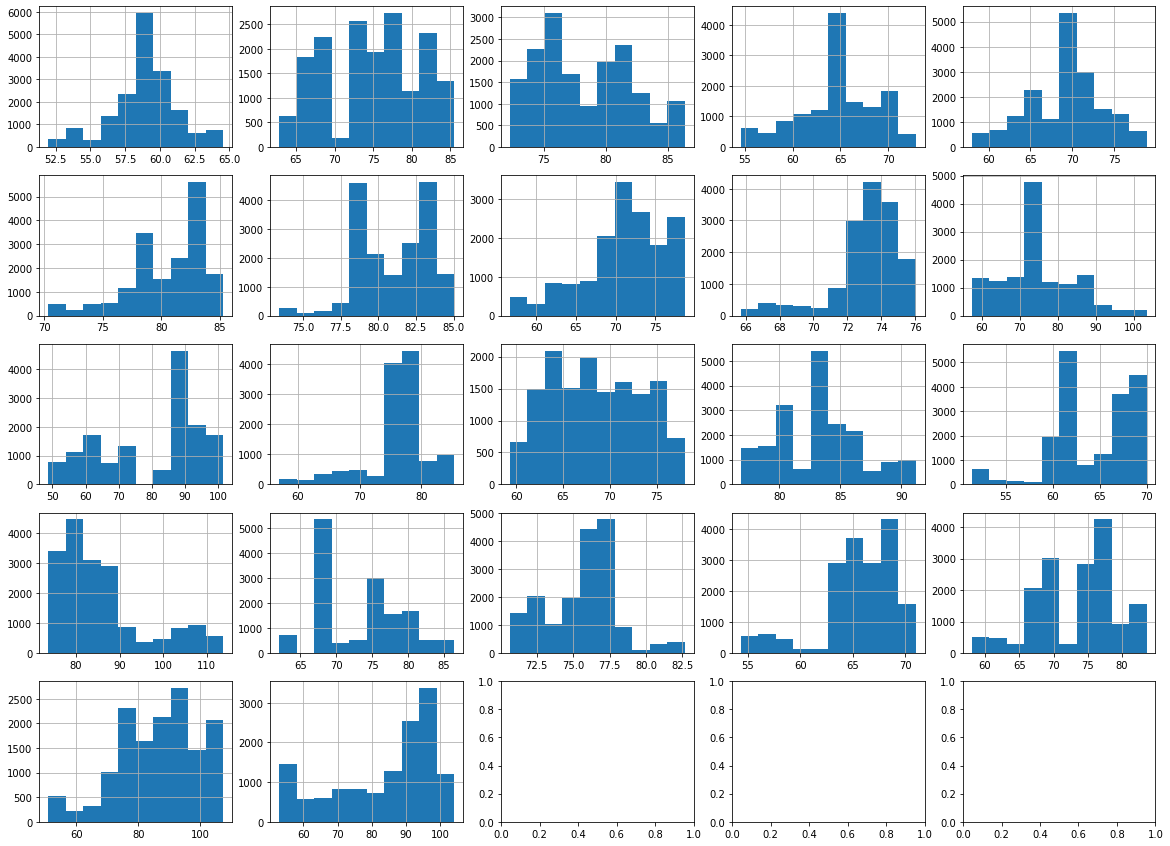

In [18]:
# Heart Rate Histogram

fig, axs = plt.subplots(5, 5, figsize=(20, 15))
for ax, subject in zip(axs.flatten(), subjects):
    df[df['subject_id'] == subject]['HR'].hist(ax=ax)

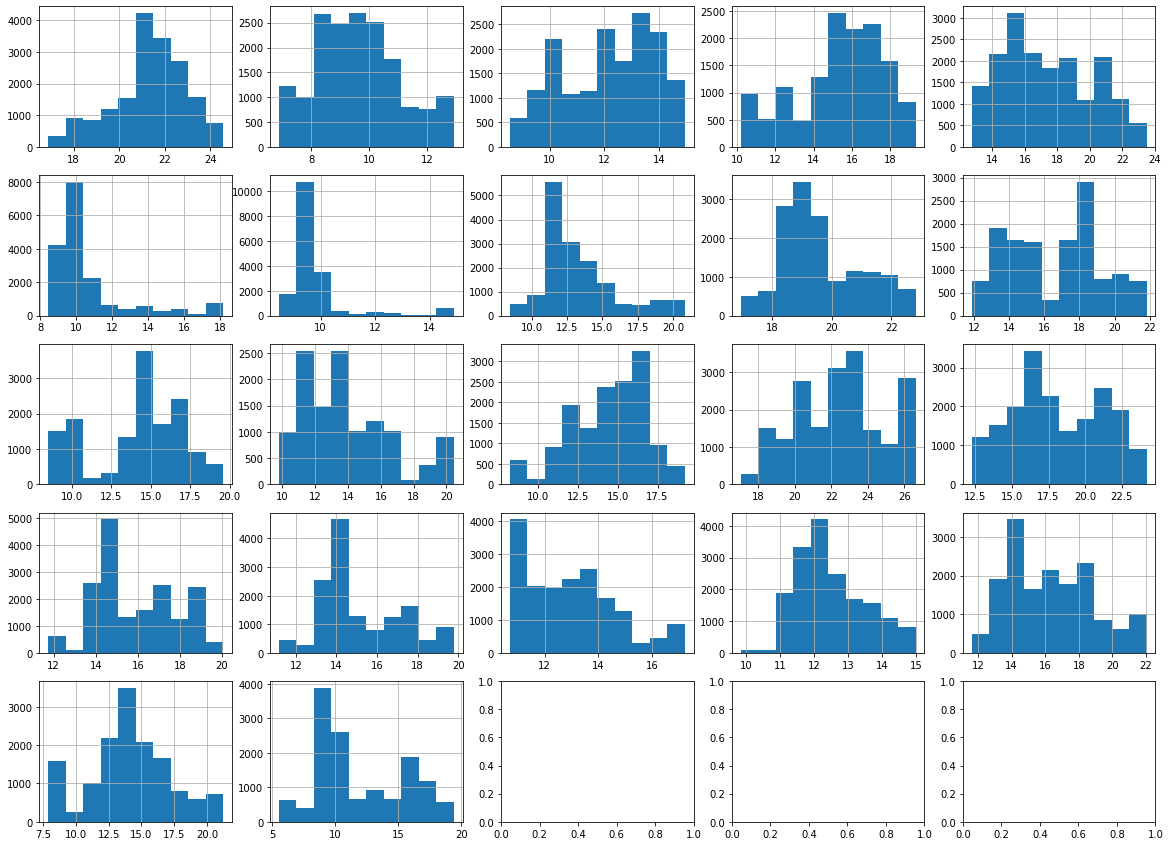

In [19]:
# RMSDD histogram

fig, axs = plt.subplots(5, 5, figsize=(20, 15))
for ax, subject in zip(axs.flatten(), subjects):
    df[df['subject_id'] == subject]['RMSSD'].hist(ax=ax)

In [20]:
df[df['subject_id'] == 1][['condition', 'NasaTLX class']][40:50]

,condition,NasaTLX class
814,time pressure,medium
824,interruption,medium
830,no stress,medium
866,no stress,medium
874,time pressure,medium
880,time pressure,medium
894,no stress,medium
902,time pressure,medium
906,no stress,medium
915,no stress,medium


In [21]:
df.head()

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,...,KURT_SQUARE,HR_SQRT,MEAN_RR_MEAN_MEAN_REL_RR,SD2_LF,HR_LF,HR_HF,HF_VLF,NasaTLX class,Condition Label,NasaTLX Label
0,1174.144734,1220.305100,146.274795,20.453938,20.453875,7.151424,52.018538,21.266667,1.933333,14.467900,...,0.099908,7.212388,2.199784e+07,0.153091,0.038591,43.650130,0.000447,high,1,2
1,895.342387,893.943175,56.174431,9.294380,9.294329,6.043914,67.278216,0.933333,0.000000,6.574276,...,0.203463,8.202330,2.879915e+07,0.241013,0.204811,6.144360,0.015995,high,1,2
2,764.218684,767.859965,77.160764,11.788299,11.787062,6.545539,79.342692,3.066667,0.000000,8.337493,...,0.138674,8.907452,-3.266219e+06,0.155760,0.113586,3.932715,0.013721,medium,1,1
3,854.776805,830.149445,84.950716,10.797540,10.796497,7.867599,70.867408,2.733333,0.200000,7.636824,...,0.698643,8.418278,-5.553280e+06,0.223233,0.131948,4.348861,0.033438,low,2,0
4,1093.290552,1121.317600,145.395568,17.550094,17.550090,8.284603,55.994337,16.066667,0.933333,12.413929,...,0.058267,7.482936,-6.849979e+07,0.215492,0.058790,33.929483,0.000479,medium,2,1


In [43]:
columns_to_drop = ['subject_id', 'HR', 'condition', 'Condition Label', 'NasaTLX class', 'NasaTLX Label']
main_columns_to_keep = ['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR',
       'pNN25', 'pNN50']
# Mean RR: Mean of all RR intervals
# Median RR: Median of all RR intervals
# SDRR: Standard Deviation of all intervals
# RMSDD: Square root of the mean of the sum of the squares of the difference between adjacent RR intervals
# SDSD: Standard deviation of all interval of differences between adjacent RR intervals 
# SDRR_RMSDD: Ratio of SDRR over RMSSD
# HR: Heart Rate
# pNN25: % of adjacent RR intervals differing by more than 25 ms
# pNN50: % of adjacent RR intervals differing by more than 50 ms

In [23]:
# Using just HR to predict stress 
X = df['HR'].values.reshape(-1, 1)
y = df['NasaTLX Label'].values

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [25]:
rf = RandomForestClassifier()
rf_grid = {'n_estimators': [100, 250, 500], 
           'max_depth': [2, 3]}

In [22]:
clf1 = GridSearchCV(rf, rf_grid)
clf1.fit(X_train, y_train)

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [24]:
predictions_a = clf1.predict(X_test)

In [26]:
accuracy_score(y_test, predictions_a)

0.4313939105073821

In [29]:
# Using selected columns to predict stress
X2 = df[main_columns_to_keep]
y2 = df['NasaTLX Label'].values

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2)

In [31]:
rf_grid = {'n_estimators': [100], 
           'max_depth': [None]}
clf2 = GridSearchCV(rf, rf_grid)
clf2.fit(X_train, y_train)

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [32]:
accuracy_score(y_test, clf2.predict(X_test))

0.9999205619673396

In [31]:
# Using HR and HRV to predict stress
X3 = df[['HR', 'RMSSD']]
y3 = df['NasaTLX Label'].values
X_train, X_test, y_train, y_test = train_test_split(X3, y3)

In [32]:
clf3 = GridSearchCV(rf, rf_grid)
clf3.fit(X_train, y_train)

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [33]:
accuracy_score(y_test, clf3.predict(X_test))

0.9340777811822649

In [34]:
# Using just HRV to predict stress
X4 = df[['RMSSD']]
y4 = df['NasaTLX Label'].values
X_train, X_test, y_train, y_test = train_test_split(X4, y4)
clf4 = GridSearchCV(rf, rf_grid)
clf4.fit(X_train, y_train)

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [35]:
accuracy_score(y_test, clf4.predict(X_test))

0.4089356438452547

In [34]:
# Using selected columns but ignoring a single participant
X5 = df[df['subject_id'] != 2]
X5 = X5[['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'pNN25', 'pNN50']]
X5 = StandardScaler().fit_transform(X5)
y5 = df[df['subject_id'] != 2]['NasaTLX Label'].values
X_train, X_test, y_train, y_test = train_test_split(X5, y5)

clf5 = GridSearchCV(rf, rf_grid)
clf5.fit(X_train, y_train)

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [45]:
cols = ['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'pNN25', 'pNN50']
sorted(list(zip(cols, clf5.best_estimator_.feature_importances_)), key=lambda x: x[1])

[('SDRR', 0.07299575635595949),
 ('pNN50', 0.08892357605086072),
 ('RMSSD', 0.09817120128573988),
 ('SDSD', 0.10593034531225223),
 ('pNN25', 0.11775669861519959),
 ('SDRR_RMSSD', 0.14588059525351568),
 ('MEDIAN_RR', 0.18268196713205131),
 ('MEAN_RR', 0.18765985999442122)]

In [38]:
accuracy_score(y_test, clf5.predict(X_test))

0.5524656716417911

In [39]:
classification_report(y_test, clf5.predict(X_test))

'              precision    recall  f1-score   support\n\n           0       0.74      0.22      0.34     25103\n           1       0.52      0.71      0.60     29392\n           2       0.55      0.68      0.61     29255\n\n    accuracy                           0.55     83750\n   macro avg       0.60      0.54      0.52     83750\nweighted avg       0.60      0.55      0.53     83750\n'

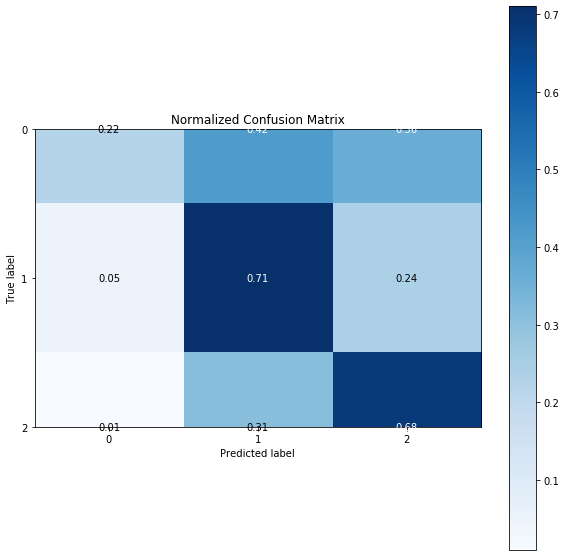

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))
skplt.metrics.plot_confusion_matrix(y_test, clf5.predict(X_test), normalize=True, ax=ax)

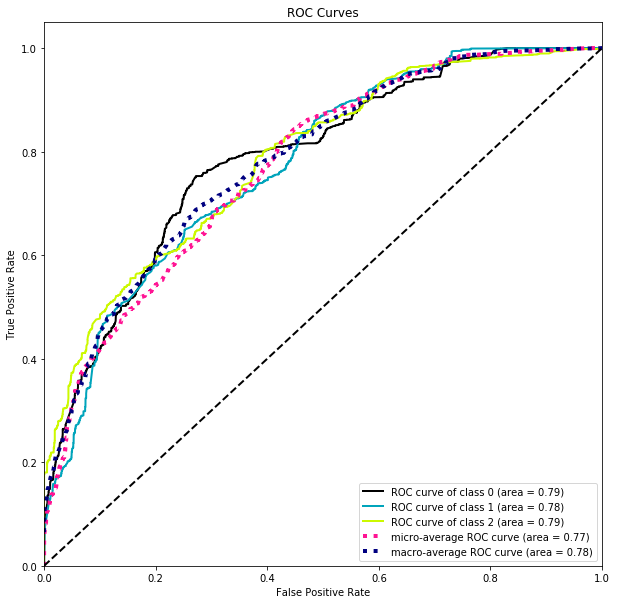

In [41]:
fig, ax = plt.subplots(figsize=(10, 10))
skplt.metrics.plot_roc(y_test, clf5.predict_proba(X_test), ax=ax)

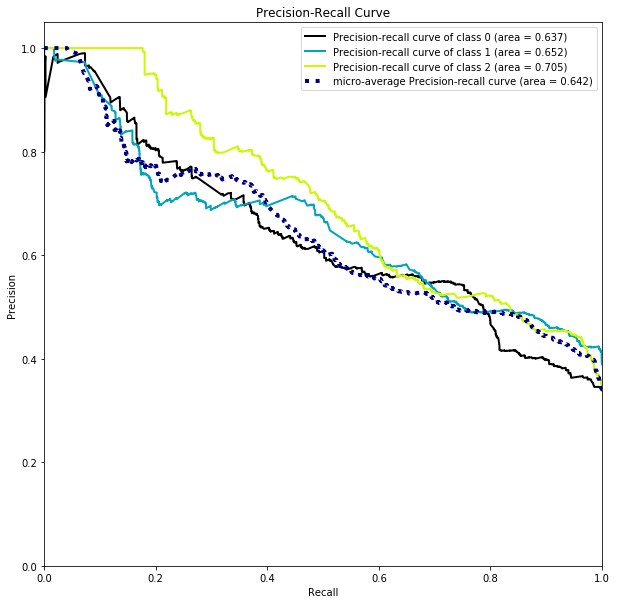

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
skplt.metrics.plot_precision_recall(y_test, clf5.predict_proba(X_test), ax=ax)

In [49]:
X5_test = df[df['subject_id'] == 6][['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'pNN25', 'pNN50']]
y5_test = df[df['subject_id'] == 6]['NasaTLX Label'].values
accuracy_score(y5_test, clf5.predict(X5_test))

0.06843843204090327

In [111]:
df['RMSSD_LOG'] = np.log(df['RMSSD'])

In [125]:
POSSIBLE_COLUMNS = ['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR',
       'pNN25', 'pNN50', 'SD1', 'SD2', 'KURT', 'SKEW', 'MEAN_REL_RR',
       'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR',
       'SDRR_RMSSD_REL_RR', 'KURT_REL_RR', 'SKEW_REL_RR', 'VLF', 'VLF_PCT',
       'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF',
       'HF_LF', 'sampen', 'higuci', 'MEAN_RR_LOG',
       'MEAN_RR_SQRT', 'TP_SQRT', 'MEDIAN_REL_RR_LOG', 'RMSSD_REL_RR_LOG',
       'SDSD_REL_RR_LOG', 'VLF_LOG', 'LF_LOG', 'HF_LOG', 'TP_LOG', 'LF_HF_LOG',
       'RMSSD_LOG', 'SDRR_RMSSD_LOG', 'pNN25_LOG', 'pNN50_LOG', 'SD1_LOG',
       'KURT_YEO_JONSON', 'SKEW_YEO_JONSON', 'MEAN_REL_RR_YEO_JONSON',
       'SKEW_REL_RR_YEO_JONSON', 'LF_BOXCOX', 'HF_BOXCOX', 'SD1_BOXCOX',
       'KURT_SQUARE', 'HR_SQRT', 'MEAN_RR_MEAN_MEAN_REL_RR', 'SD2_LF', 'HR_LF',
       'HR_HF', 'HF_VLF']

COLUMNS_TO_KEEP = ['MEAN_RR', 'MEDIAN_RR', 'SDRR',
                   'RMSSD', 'RMSSD_LOG', 'SDSD', 'SDRR_RMSSD', 'pNN25', 'pNN50',
                   'HR']

def rf_grid():
    return {'n_estimators': [100, 250], 'max_depth': [2, 3]}

def rf_for_subject_subset(df, subject_threshold):
   included_df = df[df['subject_id'] <= subject_threshold]
   X = included_df
   X = X[COLUMNS_TO_KEEP]
   X = StandardScaler().fit_transform(X)
   y = included_df['NasaTLX Label'].values
   X_train, X_test, y_train, y_test = train_test_split(X, y)
   clf = GridSearchCV(rf, rf_grid())
   clf.fit(X_train, y_train)
   print(f'Accuracy Score for Included Subset: {accuracy_score(y_test, clf.predict(X_test))}')
   return clf

def test_rf_on_excluded_subset(clf, subject_threshold):
    excluded_df = df[df['subject_id'] > subject_threshold]
    X_test = excluded_df[COLUMNS_TO_KEEP]
    X_test = StandardScaler().fit_transform(X_test)
    y_test = excluded_df['NasaTLX Label'].values
    print('Accuracy Score for Excluded Subset')
    return accuracy_score(y_test, clf.predict(X_test))

def calibrate_rf_with_sample_of_excluded_subset(df, subject_threshold, samples_per_subject):
    subset_df = df[df['subject_id'] <= subject_threshold]
    excluded_df = df[df['subject_id'] > subject_threshold]
    copy_of_excluded_df = excluded_df.copy()
    random_samples_idxs = []

    for i in copy_of_excluded_df['subject_id'].unique():
        random_sample = df[df['subject_id'] == i].sample(n=samples_per_subject)
        random_samples_idxs.append(random_sample.index)
        subset_df = pd.concat([subset_df, random_sample])
        
    print(f'TOTAL IDXS: {len(np.array(random_samples_idxs).flatten())}')
    excluded_df = excluded_df.drop(np.array(random_samples_idxs).flatten())

    calibrated_rf = rf_for_subject_subset(subset_df, subject_threshold)
    # remove random sample from excluded df for test
    excluded_df = excluded_df.drop(np.array(random_samples_idxs).flatten())

    X_test= excluded_df[COLUMNS_TO_KEEP]
    X_test= StandardScaler().fit_transform(X_test)
    y_test= excluded_df['NasaTLX Label'].values
    print(f'Accuracy Score for Excluded Subset: {accuracy_score(y_test, calibrated_rf.predict(X_test))}')
    return calibrated_rf

In [72]:
rf_for_subset_of_10 = rf_for_subject_subset(df, 10)

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score: 0.743288052198096


In [74]:
rf_for_subset_of_10.best_params_

{'max_depth': 3, 'n_estimators': 500}

In [73]:
test_rf_on_excluded_subset(rf_for_subset_of_10, 10)

0.4635668237288804

In [126]:
calibrate_rf_with_sample_of_excluded_subset(df, 10, 500)

TOTAL IDXS: 6500


In [119]:
calibrated_rf = calibrate_rf_with_sample_of_excluded_subset(df, 10, 500)

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [ ]:
calibrated_rf.best_params

In [ ]:
sorted(list(zip(cols, calibrated_rf.best_estimator_.feature_importances_)), key=lambda x: x[1])